In [ ]:
#Import packages
import time
import torch.nn as nn
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.datasets as datasets
import numpy as np
from torchvision import transforms
from torch.autograd import Variable
from PIL import Image
import torchvision.transforms.functional as TF
from torchvision.models.vgg import vgg19
import torch.nn as nn
import torch.nn.functional as F
import torch
from skimage import img_as_ubyte
import torch.nn as nn
import torch.utils.data as Data
import torchvision      # dataset
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import scipy
import numpy as np
import argparse
import glob
import imageio
from skimage import color
import numpy
import natsort
import scipy
import functools
from pytorch_msssim import ssim, ms_ssim, SSIM, MS_SSIM
import pprint
from scipy.ndimage import correlate
from scipy.ndimage.filters import gaussian_gradient_magnitude
import torchvision.datasets as dset
import torch.utils.data as data
import os
import os.path
from tkinter import *
import tkinter as tk
import tkinter.font as tkFont
from PIL import ImageTk, Image, ImageDraw
import pylab
import cv2
import h5py
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
from matplotlib.figure import Figure

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(torch.cuda.get_device_properties(0).total_memory)

11811160064


In [3]:
import multiprocessing

multiprocessing.cpu_count()

12

In [4]:
#define the hyperparameters
image_length = 256
image_width  = 256
mr_channels  = 1
gray_channels = 1
pet_channels = 4    
rgb_channels = 3     
batch_size   = 1
EPOCH = 50
learning_rate = 0.002 

In [5]:
#load the test input MRI dataset
filenames = os.listdir('C:/Users/horan/Desktop/FuseVis/MRI/')
dataset = os.path.join(os.getcwd(), 'C:/Users/horan/Desktop/FuseVis/MRI/')
data = glob.glob(os.path.join(dataset, "*.gif"))
data = natsort.natsorted(data,reverse=False)
test_mri = np.zeros((len(data), image_width,image_length))
for i in range(len(data)):
    test_mri[i,:,:] =(imageio.imread(data[i]))
    test_mri[i,:,:] =(test_mri[i,:,:] - np.min(test_mri[i,:,:])) / (np.max(test_mri[i,:,:]) - np.min(test_mri[i,:,:]))
    test_mri[i,:,:] = np.float32(test_mri[i,:,:])

In [6]:
#expand dimension to add the channel
test_mri = np.expand_dims(test_mri,axis=1)
#verify the shape matches the pytorch standard
test_mri.shape

(1, 1, 256, 256)

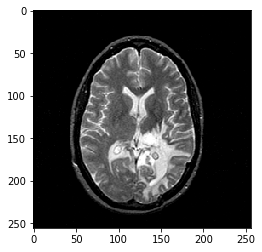

In [7]:
#verify the test mri image
#test_mri = test_mri[0,:,:,:]
#test_mri = np.expand_dims(test_mri,axis=0)
plt.imshow(test_mri[0,0,:,:],'gray')
#plt.savefig('MRI.png', bbox_inches = 'tight',pad_inches = 0,dpi=200)

In [8]:
#convert the MRI Testing data to pytorch tensor
test_mri_tensor = torch.from_numpy(test_mri).float()
test_mri_tensor = test_mri_tensor.to(device)
print(test_mri_tensor.shape)
test_mri_tensor.requires_grad =True

torch.Size([1, 1, 256, 256])


In [9]:
#load the test input PET dataset
filenames = os.listdir('C:/Users/horan/Desktop/FuseVis/PET/')
dataset = os.path.join(os.getcwd(), 'C:/Users/horan/Desktop/FuseVis/PET/')
data = glob.glob(os.path.join(dataset, "*.png"))
data = natsort.natsorted(data,reverse=False)
test_pet = np.zeros((len(data), image_width,image_length))
for i in range(len(data)):
    test_pet[i,:,:] =(imageio.imread(data[i]))
    test_pet[i,:,:] =(test_pet[i,:,:] - np.min(test_pet[i,:,:])) / (np.max(test_pet[i,:,:]) - np.min(test_pet[i,:,:]))
    test_pet[i,:,:] = np.float32(test_pet[i,:,:])

In [10]:
#expand dimension to add the channel
test_pet = np.expand_dims(test_pet,axis=1)
#verify the shape matches the pytorch standard
test_pet.shape 

(1, 1, 256, 256)

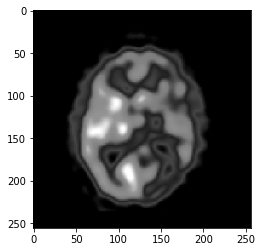

In [11]:
#verify the test pet image
#test_pet = test_pet[2,:,:,:]
#test_pet = np.expand_dims(test_pet,axis=0)
plt.imshow(test_pet[0,0,:,:],'gray')

In [12]:
#convert the MRI Testing data to pytorch tensor
test_pet_tensor = torch.from_numpy(test_pet).float()
test_pet_tensor = test_pet_tensor.to(device)
print(test_pet_tensor.shape)
test_pet_tensor.requires_grad =True

torch.Size([1, 1, 256, 256])


# define the FunFuseAn model

In [13]:
#define the network
class FunFuseAn(nn.Module):
    def  __init__(self):
        super(FunFuseAn, self).__init__()
        #####mri lf layer 1#####
        self.mri_lf = nn.Sequential( #input shape (,1,256,256)
                         nn.Conv2d(in_channels=1, out_channels=16, kernel_size=9, stride=1, padding=4),
                         nn.BatchNorm2d(16),
                         nn.LeakyReLU(0.2,inplace=True)) #output shape (,16,256,256)   
        #####mri hf layers#####
        self.mri_hf = nn.Sequential(  #input shape (,1,256,256)
                         nn.Conv2d(in_channels = 1, out_channels = 16, kernel_size  = 3, stride= 1, padding = 1),
                         nn.BatchNorm2d(16),
                         nn.LeakyReLU(0.2,inplace=True),
                         nn.Conv2d(in_channels  = 16, out_channels = 32, kernel_size = 3, stride = 1, padding = 1),
                         nn.BatchNorm2d(32),
                         nn.LeakyReLU(0.2,inplace=True),
                         nn.Conv2d(in_channels  = 32, out_channels = 64, kernel_size  = 3, stride = 1, padding = 1),
                         nn.BatchNorm2d(64),
                         nn.LeakyReLU(0.2,inplace=True)) #output shape (,64,256,256)
        #####pet lf layer 1#####
        self.pet_lf = nn.Sequential( #input shape (,1,256,256)
                         nn.Conv2d(in_channels=1, out_channels=16, kernel_size=7, stride=1, padding=3),
                         nn.BatchNorm2d(16),
                         nn.LeakyReLU(0.2,inplace=True)) #output shape (,16,256,256)   
        #####pet hf layers#####
        self.pet_hf = nn.Sequential(  #input shape (,1,256,256)
                         nn.Conv2d(in_channels = 1, out_channels = 16, kernel_size  = 5, stride= 1, padding = 2),
                         nn.BatchNorm2d(16),
                         nn.LeakyReLU(0.2,inplace=True),
                         nn.Conv2d(in_channels  = 16, out_channels = 32, kernel_size = 5, stride = 1, padding = 2),
                         nn.BatchNorm2d(32),
                         nn.LeakyReLU(0.2,inplace=True),
                         nn.Conv2d(in_channels  = 32, out_channels = 64, kernel_size  = 3, stride = 1, padding = 1),
                         nn.BatchNorm2d(64),
                         nn.LeakyReLU(0.2,inplace=True)) #output shape (,64,256,256)
        #####reconstruction layer 1#####
        self.recon1 = nn.Sequential(  #input shape (, 64, 256, 256)
                          nn.Conv2d(in_channels  = 64,  out_channels = 32, kernel_size  = 5, stride = 1, padding = 2),
                          nn.BatchNorm2d(32),
                          nn.LeakyReLU(0.2,inplace=True),
                          nn.Conv2d(in_channels  = 32, out_channels = 16, kernel_size  = 5, stride = 1, padding = 2),
                          nn.BatchNorm2d(16),
                          nn.LeakyReLU(0.2,inplace=True)) #output shape (,16, 256, 256)
        
        #####reconstruction layer 2#####
        self.recon2 = nn.Sequential(      #input shape (,16, 256, 256)
                            nn.Conv2d(in_channels  = 16, out_channels = 1, kernel_size  = 5, stride = 1, padding = 2))   #output shape (,1,256,256)

    def forward(self, x, y):
        #mri lf layer 1
        x1 = self.mri_lf(x)
        #mri hf layers
        x2 = self.mri_hf(x)
        #pet lf layer 1
        y1 = self.pet_lf(y)
        #pet hf layers
        y2 = self.pet_hf(y)
        #high frequency fusion layer
        fuse_hf = x2 + y2
        #reconstruction layer1
        recon_hf = self.recon1(fuse_hf)
        #low frequency fusion layer
        fuse_lf = (x1 + y1 + recon_hf)/3
        #reconstruction layer2
        recon3 = self.recon2(fuse_lf)
        #tanh layer
        fused = torch.tanh(recon3)      
        return fused
        #execute the network

model1 = FunFuseAn().to(device)
model1 = model1.float()
print(model1)

FunFuseAn(
  (mri_lf): Sequential(
    (0): Conv2d(1, 16, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace)
  )
  (mri_hf): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2, inplace)
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.2, inplace)
  )
  (pet_lf): Sequential(
    (0): Conv2d(1, 16, kernel_size=(7, 7), stride=(1, 1), paddi

# define the FusionGAN model

In [14]:
#define the generator network
class Generator(nn.Module):
    def  __init__(self):
        super(Generator, self).__init__()
        #####Layer 1#####
        self.gen_layer1 = nn.Sequential( #input shape (,2,256,256)
                         nn.Conv2d(in_channels=2, out_channels=256, kernel_size=5, stride=1, padding=2),
                         nn.BatchNorm2d(256),
                         nn.LeakyReLU(0.2,inplace=True)) #output shape (,256,256,256)   
        #####Layer 2#####
        self.gen_layer2 = nn.Sequential( #input shape (,256,256,256)
                         nn.Conv2d(in_channels=256, out_channels=128, kernel_size=5, stride=1, padding=2),
                         nn.BatchNorm2d(128),
                         nn.LeakyReLU(0.2,inplace=True)) #output shape (,128,256,256)   
        #####Layer 3#####
        self.gen_layer3 = nn.Sequential( #input shape (,128,256,256)
                         nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, stride=1, padding=1),
                         nn.BatchNorm2d(64),
                         nn.LeakyReLU(0.2,inplace=True)) #output shape (,64,256,256)   
        #####Layer 4#####
        self.gen_layer4 = nn.Sequential( #input shape (,64,256,256)
                         nn.Conv2d(in_channels=64, out_channels=32, kernel_size=3, stride=1, padding=1),
                         nn.BatchNorm2d(32),
                         nn.LeakyReLU(0.2,inplace=True)) #output shape (,32,256,256)  
        #####Layer 5#####
        self.gen_layer5 = nn.Sequential( #input shape (,32,256,256)
                         nn.Conv2d(in_channels=32, out_channels=1, kernel_size=1, stride=1))  #output shape (,1,256,256)  


    def forward(self, x, y):
        #concat the input images
        concat = torch.cat((x,y),1)
        #layer 1
        x1 = self.gen_layer1(concat)
        #layer 2
        x2 = self.gen_layer2(x1)
        #layer 3
        x3 = self.gen_layer3(x2)
        #layer 4
        x4 = self.gen_layer4(x3)
        #layer 5
        x5 = self.gen_layer5(x4)
        #tanh layer
        fused = torch.tanh(x5)      
        return fused

model2 = Generator().to(device)
model2 = model2.float()
print(model2)

Generator(
  (gen_layer1): Sequential(
    (0): Conv2d(2, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace)
  )
  (gen_layer2): Sequential(
    (0): Conv2d(256, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace)
  )
  (gen_layer3): Sequential(
    (0): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace)
  )
  (gen_layer4): Sequential(
    (0): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace)
  )
  (gen_l

# define the FusionDN model

In [15]:
#define the generator network
class FusionDN(nn.Module):
    def  __init__(self):
        super(FusionDN, self).__init__()
        ##### Encoder Layer 1#####
        self.layer1 = nn.Sequential( #input shape (,2,256,256)
                         nn.Conv2d(in_channels=2, out_channels=48, kernel_size=3, stride=1, padding=1),
                         nn.BatchNorm2d(48),
                         nn.ReLU())        
        ##### Encoder Layer 2#####
        self.layer2 = nn.Sequential( 
                         nn.Conv2d(in_channels=48, out_channels=48, kernel_size=3, stride=1, padding=1),
                         nn.BatchNorm2d(48),
                         nn.ReLU(),
                         nn.Conv2d(in_channels=48, out_channels=48, kernel_size=3, stride=1, padding=1),
                         nn.BatchNorm2d(48),
                         nn.ReLU())    
        ##### Encoder Layer 3#####
        self.layer3 = nn.Sequential(
                         nn.Conv2d(in_channels=96, out_channels=48, kernel_size=3, stride=1, padding=1),
                         nn.BatchNorm2d(48),
                         nn.ReLU(),
                         nn.Conv2d(in_channels=48, out_channels=48, kernel_size=3, stride=1, padding=1),
                         nn.BatchNorm2d(48),
                         nn.ReLU())     
        ##### Encoder Layer 4#####
        self.layer4 = nn.Sequential( 
                         nn.Conv2d(in_channels=144, out_channels=48, kernel_size=3, stride=1, padding=1),
                         nn.BatchNorm2d(48),
                         nn.ReLU(),
                         nn.Conv2d(in_channels=48, out_channels=48, kernel_size=3, stride=1, padding=1),
                         nn.BatchNorm2d(48),
                         nn.ReLU())      
        ##### Encoder Layer 5#####
        self.layer5 = nn.Sequential( 
                         nn.Conv2d(in_channels=192, out_channels=48, kernel_size=3, stride=1, padding=1),
                         nn.BatchNorm2d(48),
                         nn.ReLU(),
                         nn.Conv2d(in_channels=48, out_channels=48, kernel_size=3, stride=1, padding=1),
                         nn.BatchNorm2d(48),
                         nn.ReLU())        
        
        ##### Decoder Layer 1#####
        self.layer6 = nn.Sequential( 
                         nn.Conv2d(in_channels=240, out_channels=240, kernel_size=3, stride=1, padding=1),
                         nn.BatchNorm2d(240),
                         nn.ReLU())     
        ##### Decoder Layer 2#####
        self.layer7 = nn.Sequential( 
                         nn.Conv2d(in_channels=240, out_channels=128, kernel_size=3, stride=1, padding=1),
                         nn.BatchNorm2d(128),
                         nn.ReLU())       
        ##### Decoder Layer 3#####
        self.layer8 = nn.Sequential( 
                         nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, stride=1, padding=1),
                         nn.BatchNorm2d(64),
                         nn.ReLU())       
        ##### Decoder Layer 4#####
        self.layer9 = nn.Sequential(
                         nn.Conv2d(in_channels=64, out_channels=1, kernel_size=3, stride=1, padding=1),
                         nn.Tanh())         


    def forward(self, x, y):
        #Encoder 
        xy = torch.cat((x,y),1)
        x1 = self.layer1(xy)
        x2 = self.layer2(x1)
        concat1 = torch.cat((x1,x2),1)
        x3 = self.layer3(concat1)
        concat2 = torch.cat((x3,concat1),1)
        x4 = self.layer4(concat2)
        concat3 = torch.cat((x4,concat2),1)
        x5 = self.layer5(concat3)
        concat4 = torch.cat((x5,concat3),1)
        #Decoder
        x6 = self.layer6(concat4)
        x7 = self.layer7(x6)
        x8 = self.layer8(x7)
        fused = self.layer9(x8)
        return fused

model3 = FusionDN().to(device)
model3 = model3.float()
print(model3)

FusionDN(
  (layer1): Sequential(
    (0): Conv2d(2, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer2): Sequential(
    (0): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
  )
  (layer3): Sequential(
    (0): Conv2d(96, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
  )
  (laye

# define the MaskNet Model

In [16]:
#define the Mask-Net network
class MaskNet(nn.Module):
    def  __init__(self):
        super(MaskNet, self).__init__()
        #####encoder layer 1#####
        self.layer1 = nn.Sequential(  #input shape (,2,256,256)
                         nn.Conv2d(in_channels=2, out_channels=48, kernel_size=3, stride=1, padding=1),
                         nn.BatchNorm2d(48),
                         nn.LeakyReLU(0.2,inplace=True)) #output shape (,48,256,256)   
        #####encoder layer 2#####
        self.layer2 = nn.Sequential(  #input shape (,48,256,256)
                         nn.Conv2d(in_channels = 48, out_channels = 48, kernel_size  = 3, stride= 1, padding = 1),
                         nn.BatchNorm2d(48),
                         nn.LeakyReLU(0.2,inplace=True))  #output shape (,48,256,256)
        #####encoder layer 3#####
        self.layer3 = nn.Sequential(  #input shape (,96,256,256)
                         nn.Conv2d(in_channels = 96, out_channels = 48, kernel_size  = 3, stride= 1, padding = 1),
                         nn.BatchNorm2d(48),
                         nn.LeakyReLU(0.2,inplace=True))  #output shape (,48,256,256)     
        #####encoder layer 4#####
        self.layer4 = nn.Sequential(  #input shape (,144,256,256)
                         nn.Conv2d(in_channels = 144, out_channels = 48, kernel_size  = 3, stride= 1, padding = 1),
                         nn.BatchNorm2d(48),
                         nn.LeakyReLU(0.2,inplace=True))  #output shape (,48,256,256) 
        #####decoder layer 1#####
        self.layer5 = nn.Sequential(  #input shape (,192,256,256)
                         nn.Conv2d(in_channels = 192, out_channels = 192, kernel_size  = 3, stride= 1, padding = 1),
                         nn.BatchNorm2d(192),
                         nn.LeakyReLU(0.2,inplace=True))  #output shape (,192,256,256)    
        #####decoder layer 2#####
        self.layer6 = nn.Sequential(  #input shape (,192,256,256)
                         nn.Conv2d(in_channels = 192, out_channels = 128, kernel_size  = 3, stride= 1, padding = 1),
                         nn.BatchNorm2d(128),
                         nn.LeakyReLU(0.2,inplace=True))  #output shape (,128,256,256)    
        #####decoder layer 3#####
        self.layer7 = nn.Sequential(  #input shape (,128,256,256)
                         nn.Conv2d(in_channels = 128, out_channels = 64, kernel_size  = 3, stride= 1, padding = 1),
                         nn.BatchNorm2d(64),
                         nn.LeakyReLU(0.2,inplace=True))  #output shape (,64,256,256)  
        #####decoder layer 4#####
        self.layer8 = nn.Sequential(  #input shape (,64,256,256)
                         nn.Conv2d(in_channels = 64, out_channels = 1, kernel_size  = 3, stride= 1, padding = 1),
                         nn.BatchNorm2d(1),
                         nn.LeakyReLU(0.2,inplace=True))  #output shape (,1,256,256)          
 
    def forward(self, x, y):
        #encoder layer 1
        en1 = self.layer1(torch.cat((x,y),dim=1))
        #encoder layer 2
        en2 = self.layer2(en1)
        #concat layer 1
        concat1 = torch.cat((en1,en2),dim=1)
        #encoder layer 3
        en3 = self.layer3(concat1)
        #concat layer 2
        concat2 = torch.cat((concat1,en3),dim=1)
        #encoder layer 4
        en4 = self.layer4(concat2)
        #concat layer 3
        concat3 = torch.cat((concat2,en4),dim=1)
        #decoder layer 1
        dec1 = self.layer5(concat3)
        #decoder layer 2
        dec2 = self.layer6(dec1)
        #decoder layer 3
        dec3 = self.layer7(dec2)
        #decoder layer 4
        dec4 = self.layer8(dec3)
        #tanh layer
        fused = torch.tanh(dec4)      
        return fused
        #execute the network

model4 = MaskNet().to(device)
model4 = model4.float()
print(model4)

MaskNet(
  (layer1): Sequential(
    (0): Conv2d(2, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace)
  )
  (layer2): Sequential(
    (0): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace)
  )
  (layer3): Sequential(
    (0): Conv2d(96, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace)
  )
  (layer4): Sequential(
    (0): Conv2d(144, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace)
  )
  (layer5): Sequential(
    (0)

# define the DeepFuse Model

In [17]:
#define the network
class ConvLayer_DeepFuse(nn.Module):
    def __init__(self, in_channels = 1, out_channels = 16, kernel_size = 5, last = nn.ReLU):
        super().__init__()
        if kernel_size == 5:
            padding = 2
        elif kernel_size == 7:
            padding = 3
        self.main = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size = kernel_size, stride = 1, padding = padding),
            nn.BatchNorm2d(out_channels),
            last()
        )

    def forward(self, x):
        out = self.main(x)
        return out

class FusionLayer(nn.Module):
    def forward(self, x, y):
        return x + y

# -------------------------------------------------------------------------------------------------------
#   Define model
# -------------------------------------------------------------------------------------------------------
class DeepFuse(nn.Module):
    def __init__(self):
        super(DeepFuse, self).__init__()
        self.layer1 = ConvLayer_DeepFuse(1, 16, 5, last = nn.LeakyReLU)
        self.layer2 = ConvLayer_DeepFuse(16, 32, 7)
        self.layer3 = FusionLayer()
        self.layer4 = ConvLayer_DeepFuse(32, 32, 7, last = nn.LeakyReLU)
        self.layer5 = ConvLayer_DeepFuse(32, 16, 5, last = nn.LeakyReLU)
        self.layer6 = ConvLayer_DeepFuse(16, 1, 5, last = nn.Tanh)

    def setInput(self, y_1, y_2):
        self.y_1 = y_1
        self.y_2 = y_2

    def forward(self):
        c11 = self.layer1(self.y_1)
        c12 = self.layer1(self.y_2)
        c21 = self.layer2(c11)
        c22 = self.layer2(c12)
        f_m = self.layer3(c21, c22)
        c3  = self.layer4(f_m)
        c4  = self.layer5(c3)
        c5  = self.layer6(c4)
        return c5

model5 = DeepFuse().to(device)
model5 = model5.float()
print(model5)

DeepFuse(
  (layer1): ConvLayer_DeepFuse(
    (main): Sequential(
      (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
  )
  (layer2): ConvLayer_DeepFuse(
    (main): Sequential(
      (0): Conv2d(16, 32, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
  )
  (layer3): FusionLayer()
  (layer4): ConvLayer_DeepFuse(
    (main): Sequential(
      (0): Conv2d(32, 32, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
  )
  (layer5): ConvLayer_DeepFuse(
    (main): Sequential(
      (0): Conv2d(32, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (1): BatchNorm2d(16, e

# define the DeepPedestrian Model

In [18]:
#define the fusion network
#define the network
class DeepPedestrian(nn.Module):
    def  __init__(self):
        super(DeepPedestrian, self).__init__()
        #####layer 1#####
        self.conv1 = nn.Sequential(                             #input shape  (,2,256,256)
                         nn.Conv2d(in_channels=2, out_channels=48, kernel_size=3, stride=1, padding=1),
                         nn.ReLU(),
                         nn.Conv2d(in_channels = 48, out_channels = 48, kernel_size  = 3, stride= 1, padding = 1),
                         nn.ReLU(),
                         nn.Conv2d(in_channels = 48, out_channels = 48, kernel_size  = 3, stride= 1, padding = 1),
                         nn.ReLU(),
                         nn.Conv2d(in_channels = 48, out_channels = 48, kernel_size  = 3, stride= 1, padding = 1)
                         )                                     #output shape (,48,256,256)   
        #####layer 2#####
        self.conv2 = nn.Sequential(                            #input shape  (,48,256,256)
                         nn.ReLU(),
                         nn.Conv2d(in_channels=48, out_channels=48, kernel_size=3, stride=1, padding=1),
                         nn.ReLU(),
                         nn.Conv2d(in_channels = 48, out_channels = 48, kernel_size  = 3, stride= 1, padding = 1),
                         nn.ReLU(),
                         nn.Conv2d(in_channels = 48, out_channels = 48, kernel_size  = 3, stride= 1, padding = 1),
                         nn.ReLU(),
                         nn.Conv2d(in_channels = 48, out_channels = 48, kernel_size  = 3, stride= 1, padding = 1)
                         )                                     #output shape (,48,256,256)   
        #####layer 3#####
        self.conv3 = nn.Sequential(                            #input shape  (,48,256,256)
                         nn.ReLU(), 
                         nn.Conv2d(in_channels = 48, out_channels = 48, kernel_size=3, stride=1, padding=1),
                         nn.ReLU(),
                         nn.Conv2d(in_channels = 48, out_channels = 48, kernel_size  = 3, stride= 1, padding = 1),
                         nn.ReLU(),
                         nn.Conv2d(in_channels = 48, out_channels = 48, kernel_size  = 3, stride= 1, padding = 1),
                         nn.ReLU(),
                         nn.Conv2d(in_channels = 48, out_channels = 48, kernel_size  = 3, stride= 1, padding = 1)
                         )                                     #output shape (,48,256,256)     
        #####layer 4#####
        self.conv4 = nn.Sequential(                            #input shape  (,48,256,256)
                         nn.ReLU(), 
                         nn.Conv2d(in_channels = 48, out_channels = 48, kernel_size=3, stride=1, padding=1),
                         nn.ReLU(),
                         nn.Conv2d(in_channels = 48, out_channels = 48, kernel_size  = 3, stride= 1, padding = 1),
                         nn.ReLU(),
                         nn.Conv2d(in_channels = 48, out_channels = 48, kernel_size  = 3, stride= 1, padding = 1),
                         nn.ReLU(),
                         nn.Conv2d(in_channels = 48, out_channels = 48, kernel_size  = 3, stride= 1, padding = 1)
                         )                                      #output shape (,48,256,256)  
        #####layer 5#####
        self.conv5 = nn.Sequential(                             #input shape (, 48, 256, 256)
                          nn.ReLU(),
                          nn.Conv2d(in_channels  = 48,  out_channels = 1, kernel_size  = 3, stride = 1, padding = 1)) 
                                                                #output shape (,1, 256, 256)
        
    def forward(self, x, y):
        #layer 1
        x1 = self.conv1(torch.cat((x,y),dim=1))
        #layer 2
        x2 = self.conv2(x1)
        #residual layer
        x3 = x1+x2
        #layer 3
        x4 = self.conv3(x3)
        #layer 4
        x5 = self.conv4(x4)
        #residual layer
        x6 = x4 + x5
        #layer 5
        fused = self.conv5(x6)
        return fused
        #execute the network

model6 = DeepPedestrian().to(device)
model6 = model6.float()
print(model6)

DeepPedestrian(
  (conv1): Sequential(
    (0): Conv2d(2, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU()
    (6): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (conv2): Sequential(
    (0): ReLU()
    (1): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (2): ReLU()
    (3): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (conv3): Sequential(
    (0): ReLU()
    (1): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (2): ReLU()
    (3): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(

# define the VIFNet model

In [19]:
#define the fusion network
#define the fusion network
class ConvLayer(torch.nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, is_last=False):
        super(ConvLayer, self).__init__()
        reflection_padding = int(np.floor(kernel_size / 2))
        self.reflection_pad = nn.ReflectionPad2d(reflection_padding)
        self.conv2d = nn.Conv2d(in_channels, out_channels, kernel_size, stride)
        self.dropout = nn.Dropout2d(p=0.5)
        self.is_last = is_last

    def forward(self, x):
        out = self.reflection_pad(x)
        out = self.conv2d(out)
        if self.is_last is False:
            out = F.relu(out, inplace=True)
        return out

# Dense convolution unit
class DenseConv2d(torch.nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride):
        super(DenseConv2d, self).__init__()
        self.dense_conv = ConvLayer(in_channels, out_channels, kernel_size, stride)

    def forward(self, x):
        out = self.dense_conv(x)
        out = torch.cat([x, out], 1)
        return out

# Dense Block unit image1
class DenseBlock1(torch.nn.Module):
    def __init__(self, in_channels, kernel_size, stride):
        super(DenseBlock1, self).__init__()
        out_channels_def = 16
        denseblock1 = []
        denseblock1 += [DenseConv2d(in_channels, out_channels_def, kernel_size, stride),
                       DenseConv2d(in_channels+out_channels_def, out_channels_def, kernel_size, stride),
                       DenseConv2d(in_channels+out_channels_def*2, out_channels_def, kernel_size, stride)]
        self.denseblock1 = nn.Sequential(*denseblock1)

    def forward(self, x):
        out = self.denseblock1(x)
        return out
    
# Dense Block unit image1
class DenseBlock2(torch.nn.Module):
    def __init__(self, in_channels, kernel_size, stride):
        super(DenseBlock2, self).__init__()
        out_channels_def = 16
        denseblock2 = []
        denseblock2 += [DenseConv2d(in_channels, out_channels_def, kernel_size, stride),
                       DenseConv2d(in_channels+out_channels_def, out_channels_def, kernel_size, stride),
                       DenseConv2d(in_channels+out_channels_def*2, out_channels_def, kernel_size, stride)]
        self.denseblock2 = nn.Sequential(*denseblock2)

    def forward(self, x):
        out = self.denseblock2(x)
        return out

# DenseFuse network
class VIFNet(nn.Module):
    def __init__(self, input_nc=1, output_nc=1):
        super(VIFNet, self).__init__()
        denseblock1 = DenseBlock1
        denseblock2 = DenseBlock2
        nb_filter = [16, 128, 64, 32, 16]
        kernel_size = 3
        stride = 1
        # encoder
        self.conv11 = ConvLayer(input_nc, nb_filter[0], kernel_size, stride)
        self.DB1    = denseblock1(nb_filter[0], kernel_size, stride)
        self.conv12 = ConvLayer(input_nc, nb_filter[0], kernel_size, stride)
        self.DB2    = denseblock2(nb_filter[0], kernel_size, stride)
        # decoder
        self.conv2 = ConvLayer(nb_filter[1], nb_filter[1], kernel_size, stride)
        self.conv3 = ConvLayer(nb_filter[1], nb_filter[2], kernel_size, stride)
        self.conv4 = ConvLayer(nb_filter[2], nb_filter[3], kernel_size, stride)
        self.conv5 = ConvLayer(nb_filter[3], nb_filter[0], kernel_size, stride)
        self.conv6 = ConvLayer(nb_filter[0], output_nc,    kernel_size, stride)
        
    def encoder1(self, input):
        x1 = self.conv11(input)
        x1_DB = self.DB1(x1)
        return x1_DB
    
    def encoder2(self, input):
        x2 = self.conv12(input)
        x2_DB = self.DB2(x2)
        return x2_DB
    
    def fusion(self, en1, en2):
        f_0 = torch.cat((en1, en2), 1)
        return f_0

    def decoder(self, f_en):
        x2 = self.conv2(f_en)
        x3 = self.conv3(x2)
        x4 = self.conv4(x3)
        x5 = self.conv5(x4)
        output = self.conv6(x5)
        return output
    
model7 = VIFNet().to(device)
model7 = model7.float()
print(model7)

VIFNet(
  (conv11): ConvLayer(
    (reflection_pad): ReflectionPad2d((1, 1, 1, 1))
    (conv2d): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
    (dropout): Dropout2d(p=0.5)
  )
  (DB1): DenseBlock1(
    (denseblock1): Sequential(
      (0): DenseConv2d(
        (dense_conv): ConvLayer(
          (reflection_pad): ReflectionPad2d((1, 1, 1, 1))
          (conv2d): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1))
          (dropout): Dropout2d(p=0.5)
        )
      )
      (1): DenseConv2d(
        (dense_conv): ConvLayer(
          (reflection_pad): ReflectionPad2d((1, 1, 1, 1))
          (conv2d): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1))
          (dropout): Dropout2d(p=0.5)
        )
      )
      (2): DenseConv2d(
        (dense_conv): ConvLayer(
          (reflection_pad): ReflectionPad2d((1, 1, 1, 1))
          (conv2d): Conv2d(48, 16, kernel_size=(3, 3), stride=(1, 1))
          (dropout): Dropout2d(p=0.5)
        )
      )
    )
  )
  (conv12): ConvLayer(
    (refl

In [51]:
#define the window
gamma = 0.6
root = Tk()  
root.title('Visualisation of fusion networks')
root.configure(background='white')

#Label the images
#fontStyle = tkFont.Font(family="Lucida Grande", size=15)
#w1 = tk.Label(root, bg='white', font=fontStyle, text="Fused Image")
#w1.grid(row=0, column=1)
#w1.pack()

#define the frame
canvasframe = Frame(root)  # define Input and output frame
buttonframe = Frame(root)  # define button frame
canvasframe.pack()  # pack the Input and Output frame
buttonframe.pack()  # pack the button frame

#define the canvas
canvas = Canvas(canvasframe, width=1805, height=940, bg = 'white')
canvas.grid(row=0, column=0)


def start_mouseover(fused_tensor, model, min_, max_, guide_fused_mri, guide_fused_pet,fused_tensor_):  # function called when user clicks the button 
    # link the function to the left-mouse-click event
    obj = ButtonObject(fused_tensor, model, min_, max_, guide_fused_mri, guide_fused_pet,fused_tensor_)
    canvas.bind("<B1-Motion>", obj.Callback)
   
class ButtonObject:
    def __init__(self, arg1, arg2, arg3, arg4, arg5, arg6, arg7):
        self.arg1 = arg1
        self.arg2 = arg2
        self.arg3 = arg3
        self.arg4 = arg4
        self.arg5 = arg5
        self.arg6 = arg6
        self.arg7 = arg7

    def Callback(self, event):
        time1 = time.time()
        x_coord = event.x  # save x and y coordinates selected by the user   
        y_coord = event.y
        print('mouse position is at' + '(' + str(y_coord) + ',' + str(x_coord) + ')', end='\r')
        #display the output MRI Jacobian image
        jacobian_fuse_mri = torch.autograd.grad(self.arg1[0,0,y_coord,x_coord], test_mri_tensor, retain_graph=True, create_graph=True)[0]
        jacobian_fuse_pet = torch.autograd.grad(self.arg1[0,0,y_coord,x_coord], test_pet_tensor, retain_graph=True, create_graph=True)[0]

        jacob_ = torch.autograd.grad(self.arg7[0,0,y_coord,x_coord], test_mri_tensor, retain_graph=True, create_graph=True)[0]

        jacob_val_mri = np.squeeze(jacobian_fuse_mri.data.cpu().numpy())    
        jacob_val_pet = np.squeeze(jacobian_fuse_pet.data.cpu().numpy())
        jacob_val_numpy = np.squeeze(jacob_.data.cpu().numpy())

        x_mri = np.asarray(np.where(np.any(jacob_val_numpy, axis = 0)))
        y_mri = np.asarray(np.where(np.any(jacob_val_numpy, axis = 1)))
        minx_mri, maxx_mri, miny_mri, maxy_mri = np.min(x_mri), np.max(x_mri), np.min(y_mri), np.max(y_mri)  #return min and max coordinates
       
       
        radius = 7
        i = canvas.create_rectangle(x_coord-radius, y_coord-radius, x_coord+radius, y_coord+radius, outline = 'red')
        canvas.delete(i-16)
        
        j = canvas.create_rectangle(x_coord-radius, y_coord+650-radius, x_coord+radius, y_coord+650+radius, outline = 'red')
        canvas.delete(j-16)
        
        k = canvas.create_rectangle(x_coord+1200-radius, y_coord-radius, x_coord+1200+radius, y_coord+radius, outline = 'red')
        canvas.delete(k-16)
        
        l = canvas.create_rectangle(x_coord+1200-radius, y_coord+650-radius, x_coord+1200+radius, y_coord+650+radius, outline = 'red')
        canvas.delete(l-16)
        
        m = canvas.create_rectangle(x_coord+600-radius, y_coord-radius, x_coord+600+radius, y_coord+radius, outline = 'red')
        canvas.delete(m-16) 
        
        #color map details for the zoom images
        cmap = plt.get_cmap('viridis')
        cNorm = mpl.colors.Normalize(vmin=self.arg3, vmax=self.arg4) #re-wrapping normalization
        scalarMap = mpl.cm.ScalarMappable(norm=cNorm, cmap=cmap)
        
        path = 'C:/Users/horan/Desktop/FuseVis/Guidance images/'

        im_fused = Image.fromarray(np.uint8(self.arg1.data.cpu().numpy()[0,0,miny_mri:maxy_mri,minx_mri:maxx_mri]*255)).resize((256,256))
        im_fused = im_fused.convert("RGB")
        draw = ImageDraw.Draw(im_fused)
        draw.rectangle(((128, 128), (141, 141)), outline="Red")        
        im_out7 = ImageTk.PhotoImage(image=im_fused)
        canvas.create_image(300,0,image=im_out7,anchor=NW)
        canvas.image7 = im_out7
        plt.tight_layout()
    
        im_mri = Image.fromarray(np.uint8(test_mri[0,0,miny_mri:maxy_mri,minx_mri:maxx_mri]*255)).resize((256,256))
        im_mri = im_mri.convert("RGB")
        draw = ImageDraw.Draw(im_mri)
        draw.rectangle(((128, 128), (141, 141)), outline="Red")
        im_out8 = ImageTk.PhotoImage(image=im_mri)
        canvas.create_image(900,0,image=im_out8,anchor=NW)
        canvas.image8 = im_out8
    
        im_pet = Image.fromarray(np.uint8(test_pet[0,0,miny_mri:maxy_mri,minx_mri:maxx_mri]*255)).resize((256,256)) 
        im_pet = im_pet.convert("RGB")
        draw = ImageDraw.Draw(im_pet)
        draw.rectangle(((128, 128), (141, 141)), outline="Red")
        im_out9 = ImageTk.PhotoImage(image=im_pet)
        canvas.create_image(1500,0,image=im_out9,anchor=NW)
        canvas.image9 = im_out9  

        im_out10 = ImageTk.PhotoImage(image=Image.fromarray(np.uint8(255*scalarMap.to_rgba(jacob_val_mri)**gamma)).resize((256,256)))
        canvas.create_image(0,320,image=im_out10,anchor=NW)
        #canvas.create_text(125,590,fill="black",font=("Purisa", 11),text="Per-pixel Gradient map (Fused wrt MRI)")
        canvas.image10 = im_out10
           
        
        n = canvas.create_rectangle(x_coord-radius, y_coord+320-radius, x_coord+radius, y_coord+320+radius, outline = 'red')
        canvas.delete(n-19)
        

        im_out11 = ImageTk.PhotoImage(image=Image.fromarray(np.uint8(255*scalarMap.to_rgba(jacob_val_mri[miny_mri:maxy_mri,minx_mri:maxx_mri])**gamma)).resize((256,256)))
        canvas.create_image(300,320,image=im_out11,anchor=NW)
        canvas.image11 = im_out11
        
    
        #plt.xlim(-1.0,1.0)
        #plt.ylim(-1.0,1.0)
        #plt.plot(jacob_val_mri[y_coord,x_coord],jacob_val_pet[y_coord,x_coord],'-ro')
        #plt.xlabel('MRI pixel score (Fused wrt MRI)')
        #plt.ylabel('PET pixel score (Fused wrt PET)')
        #plt.title('Mouse position at: (' + str(y_coord) + ',' + str(x_coord) + ')')
        #plt.gca().set_aspect('equal', adjustable='box')
        #plt.draw()
        #plt.savefig(path + self.arg2 + '/Resultant images/Pixel_intensities.png', bbox_inches = 'tight',pad_inches = 0.1)
        #plt.close()
        #im_out12 = ImageTk.PhotoImage(file =path + self.arg2 + '/Resultant images/Pixel_intensities.png')
        #canvas.create_image(750,320,image=im_out12,anchor=NW)
        #canvas.image12 = im_out12
    
        
        im_out13 = ImageTk.PhotoImage(image=Image.fromarray(np.uint8(255*scalarMap.to_rgba(jacob_val_pet)**gamma)).resize((256,256)))
        canvas.create_image(1200,320,image=im_out13,anchor=NW)
        #canvas.create_text(1325,590,fill="black",font=("Purisa", 11),text="Per-pixel Gradient map (Fused wrt PET)")   
        canvas.image13 = im_out13
        
        
        o = canvas.create_rectangle(x_coord+1200-radius, y_coord+320-radius, x_coord+1200+radius, y_coord+320+radius, outline = 'red')
        canvas.delete(o-22)
    
        im_out14 = ImageTk.PhotoImage(image=Image.fromarray(np.uint8(255*scalarMap.to_rgba(jacob_val_pet[miny_mri:maxy_mri,minx_mri:maxx_mri])**gamma)).resize((256,256)))
        canvas.create_image(1500,320,image=im_out14,anchor=NW)
        canvas.image14 = im_out14
                
        #display the zoom guidance MRI images 
        im_guide_mri = Image.fromarray(np.uint8(255*scalarMap.to_rgba(self.arg5[miny_mri:maxy_mri,minx_mri:maxx_mri])**gamma)).resize((256,256))
        im_guide_mri = im_guide_mri.convert("RGB")
        draw = ImageDraw.Draw(im_guide_mri)
        draw.rectangle(((128, 128), (141, 141)), outline="Red")
        im_out15 = ImageTk.PhotoImage(image=im_guide_mri)
        canvas.create_image(300,650,image=im_out15,anchor=NW)
        canvas.image15 = im_out15
        
        #display the zoom guidance PET images 
        im_guide_pet = Image.fromarray(np.uint8(255*scalarMap.to_rgba(self.arg6[miny_mri:maxy_mri,minx_mri:maxx_mri])**gamma)).resize((256,256))
        im_guide_pet = im_guide_pet.convert("RGB")
        draw = ImageDraw.Draw(im_guide_pet)
        draw.rectangle(((128, 128), (141, 141)), outline="Red")
        im_out16 = ImageTk.PhotoImage(image=im_guide_pet)
        canvas.create_image(1500,650,image=im_out16,anchor=NW)
        canvas.image16 = im_out16
        
        time2=time.time()
        print(time2-time1)

def load_model(model):
    if model == "FunFuseAn":
        canvas.delete("all")
        #Insert MRI image to the canvas
        img_mri = ImageTk.PhotoImage(file ="C:/Users/horan/Desktop/FuseVis/MRI/MRI.gif") # load the image
        canvas.create_image(600, 0, image=img_mri, anchor=NW)
        #canvas.create_text(725,270,fill="black",font=("Purisa", 12),text="MRI image")  
        canvas.im1 = img_mri
     
        

        #Insert PET image to the canvas
        img_pet = ImageTk.PhotoImage(file ="C:/Users/horan/Desktop/FuseVis/PET/3.png") # load the image
        canvas.create_image(1200, 0, image=img_pet, anchor=NW)
        #canvas.create_text(1325,270,fill="black",font=("Purisa", 12),text="PET image")
        canvas.im2 = img_pet

        
        #load the fused image and insert into the canvas
        im_out1 = ImageTk.PhotoImage(file ="C:/Users/horan/Desktop/FuseVis/Fused/FunFuseAn/Fused.png") #load the image
        canvas.create_image(0, 0, image=im_out1, anchor=NW)
        #canvas.create_text(125,270,fill="black",font=("Purisa", 12),text="Fused image")
        canvas.image1 = im_out1
        
        
        #load the model
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        model1 =torch.load('C:/Users/horan/Desktop/FuseVis/.ipynb_checkpoints/FunFuseAn/checkpoint.pth')
        model1.eval()
        
        #predict the fused image
        fused_tensor1 = model1(test_mri_tensor.to(device), test_pet_tensor.to(device))
        fused_tensor1_numpy = fused_tensor1.data.cpu().numpy()
        
        #load the Fused wrt MRI and Fused wrt PET guidance images 
        hf = h5py.File('C:/Users/horan/Desktop/FuseVis/Guidance images/FunFuseAn/H5 Files/Jacobian_MRI.h5', 'r')
        guide_fused_mri =  np.array(hf.get('MRI_dataset'))
        hf.close()
        guide_mri_min = np.min(guide_fused_mri)
        guide_mri_max = np.max(guide_fused_mri)
        hf = h5py.File('C:/Users/horan/Desktop/FuseVis/Guidance images/FunFuseAn/H5 Files/Jacobian_PET.h5', 'r')
        guide_fused_pet =  np.array(hf.get('PET_dataset'))
        hf.close()
        guide_pet_min = np.min(guide_fused_pet)
        guide_pet_max = np.max(guide_fused_pet)  
        if (guide_mri_min > guide_pet_min):
            min_ = guide_pet_min
        else:
            min_ = guide_mri_min
        if (guide_mri_max > guide_pet_max):
            max_ = guide_mri_max
        else:
            max_ = guide_pet_max

        #color map details for the zoom images
        cmap = plt.get_cmap('viridis')
        #cNorm = mpl.colors.Normalize(vmin=min_, vmax=max_) #re-wrapping normalization
        cNorm = mpl.colors.PowerNorm(gamma=gamma, vmin=min_, vmax=max_)
        scalarMap = mpl.cm.ScalarMappable(norm=cNorm, cmap=cmap)
        
        fig = plt.figure(figsize=(0.2, 23))
        ax1 = fig.add_axes([0.05, 0.80, 0.9, 0.15])
        cb1 = mpl.colorbar.ColorbarBase(ax1,cmap=cmap,norm=cNorm,orientation='vertical')
        plt.plot()
        plt.savefig('C:/Users/horan/Desktop/FuseVis/Guidance images/FunFuseAn/Resultant images/colorbar.png', bbox_inches = 'tight',pad_inches = 0)
        plt.close()
        im_out50 = ImageTk.PhotoImage(file ='C:/Users/horan/Desktop/FuseVis/Guidance images/FunFuseAn/Resultant images/colorbar.png')
        canvas.create_image(560,650,image=im_out50,anchor=NW)
        canvas.image50 = im_out50
        
        #display the Fused wrt MRI guidance images
        #plt.imshow(guide_fused_mri,cmap='viridis', vmin=min_, vmax=max_)
        #plt.title('Guidance (Fused wrt MRI)')
        #plt.colorbar()
        #plt.savefig('C:/Users/horan/Desktop/FuseVis/Guidance images/FunFuseAn/Resultant images/Guide_Fused_MRI.png', bbox_inches = 'tight',pad_inches = 0)
        #plt.close()
        im_out2 = ImageTk.PhotoImage(image=Image.fromarray(np.uint8(255*scalarMap.to_rgba(guide_fused_mri)**gamma)).resize((256,256)))
        canvas.create_image(0,650,image=im_out2,anchor=NW)
        #canvas.create_text(125,920,fill="black",font=("Purisa", 12),text="G1: Gradient map (Fused wrt MRI)")  
        canvas.image2 = im_out2
          
        
        #display the Fused wrt PET guidance images
        #plt.imshow(guide_fused_pet,cmap='viridis', vmin=min_, vmax=max_)
        #plt.title('Guidance (Fused wrt PET)')
        #plt.colorbar()
        #plt.savefig('C:/Users/horan/Desktop/FuseVis/Guidance images/FunFuseAn/Resultant images/Guide_Fused_PET.png', bbox_inches = 'tight',pad_inches = 0)
        #plt.close()
        im_out3 = ImageTk.PhotoImage(image=Image.fromarray(np.uint8(255*scalarMap.to_rgba(guide_fused_pet)**gamma)).resize((256,256)))
        canvas.create_image(1200,650,image=im_out3,anchor=NW)
        #canvas.create_text(1325,920,fill="black",font=("Purisa", 12),text="G2: Gradient map (Fused wrt PET)") 
        canvas.image3 = im_out3
          
        
        #display the Fused RGB image
        fused_RGB = np.zeros((256,256,3),dtype=float)
        guide_fused_mri_norm = (guide_fused_mri - np.min(guide_fused_mri)) / (np.max(guide_fused_mri) - np.min(guide_fused_mri))
        guide_fused_pet_norm = (guide_fused_pet - np.min(guide_fused_pet)) / (np.max(guide_fused_pet) - np.min(guide_fused_pet))
        fused_RGB[:,:,0]  = guide_fused_mri_norm
        fused_RGB[:,:,1]  = guide_fused_pet_norm 
        fused_RGB[:,:,2]  = fused_tensor1_numpy[0,0,:,:]
        #plt.imshow(fused_RGB)
        #plt.title('R=I1 G=I2 B=Fused')
        #plt.savefig('C:/Users/horan/Desktop/FuseVis/Guidance images/FunFuseAn/Resultant images/Fused_RGB.png', bbox_inches = 'tight',pad_inches = 0)
        #plt.close()
        im_out4 = ImageTk.PhotoImage(image=Image.fromarray(np.uint8(fused_RGB*255)).resize((256,256)))
        canvas.create_image(750,650,image=im_out4,anchor=NW)
        #canvas.create_text(875,920,fill="black",font=("Purisa", 12),text="R:G1, G: G2, B: Fused")  
        canvas.image4 = im_out4
        
        
        #display the scatter plot
        guide_mri_flat   = guide_fused_mri.flatten()
        guide_pet_flat   = guide_fused_pet.flatten() 
        plt.xlim(min_, max_)
        plt.ylim(min_, max_)
        plt.scatter(guide_mri_flat,guide_pet_flat, s=0.5)
        plt.xlabel('MRI pixel score (Fused wrt MRI)')
        plt.ylabel('PET pixel score (Fused wrt PET)')
        plt.title('Scatter Plot of per-pixel gradients')
        plt.savefig('C:/Users/horan/Desktop/FuseVis/Guidance images/FunFuseAn/Resultant images/Scatter_Plot.png', pad_inches = 0)
        plt.close()
        im_out5 = ImageTk.PhotoImage(file ='C:/Users/horan/Desktop/FuseVis/Guidance images/FunFuseAn/Resultant images/Scatter_Plot.png')
        canvas.create_image(680,320,image=im_out5,anchor=NW)
        canvas.image5 = im_out5
        
        canvas.create_image(1760,650,image=im_out50,anchor=NW)
        canvas.image51 = im_out50
        
        #insert button to the middleframe and link it to "Start Mouseover"
        #button_start_mouseover = Button(buttonframe, text="Start Mouseover",command= lambda: start_mouseover(fused_tensor1, model))
        start_mouseover(fused_tensor1, model, min_, max_, guide_fused_mri, guide_fused_pet,fused_tensor1)
        #button_start_mouseover.grid(row=1, column=0, pady=0)

    if model == "FusionGAN":
        canvas.delete("all")
        #Insert MRI image to the canvas
        img_mri = ImageTk.PhotoImage(file ="C:/Users/horan/Desktop/FuseVis/MRI/MRI.gif") # load the image
        canvas.create_image(600, 0, image=img_mri, anchor=NW)
        #canvas.create_text(725,270,fill="black",font=("Purisa", 12),text="MRI image") 
        canvas.im1 = img_mri
           

        #Insert PET image to the canvas
        img_pet = ImageTk.PhotoImage(file ="C:/Users/horan/Desktop/FuseVis/PET/3.png") # load the image
        canvas.create_image(1200, 0, image=img_pet, anchor=NW)
        #canvas.create_text(1325,270,fill="black",font=("Purisa", 12),text="PET image")
        canvas.im2 = img_pet
        
        
        #load the fused image and insert into the canvas
        im_out1 = ImageTk.PhotoImage(file ="C:/Users/horan/Desktop/FuseVis/Fused/FusionGAN/Fused.png") #load the image
        canvas.create_image(0, 0, image=im_out1, anchor=NW)
        #canvas.create_text(125,270,fill="black",font=("Purisa", 12),text="Fused image")
        canvas.image1 = im_out1
        
        
        #load the funfusean model
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        model1 =torch.load('C:/Users/horan/Desktop/FuseVis/.ipynb_checkpoints/FunFuseAn/checkpoint.pth')
        model1.eval()

        #predict the fused image
        fused_tensor1 = model1(test_mri_tensor.to(device), test_pet_tensor.to(device))
        fused_tensor1_numpy = fused_tensor1.data.cpu().numpy()
        
        #load the model
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        model2 =torch.load('C:/Users/horan/Desktop/FuseVis/.ipynb_checkpoints/FusionGAN/checkpoint_gen.pth')
        model2.eval()
        #predict the fused image
        fused_tensor2 = model2(test_mri_tensor.to(device), test_pet_tensor.to(device))
        fused_tensor2_numpy = fused_tensor2.data.cpu().numpy()
        #load the Fused wrt MRI and Fused wrt PET guidance images 
        hf = h5py.File('C:/Users/horan/Desktop/FuseVis/Guidance images/FusionGAN/H5 Files/Jacobian_MRI.h5', 'r')
        guide_fused_mri =  np.array(hf.get('Jacob_MRI_dataset'))
        hf.close()
        hf = h5py.File('C:/Users/horan/Desktop/FuseVis/Guidance images/FusionGAN/H5 Files/Jacobian_PET.h5', 'r')
        guide_fused_pet =  np.array(hf.get('Jacob_PET_dataset'))
        hf.close()
        guide_mri_min = np.min(guide_fused_mri)
        guide_mri_max = np.max(guide_fused_mri)
        guide_pet_min = np.min(guide_fused_pet)
        guide_pet_max = np.max(guide_fused_pet)  
        if (guide_mri_min > guide_pet_min):
            min_ = guide_pet_min
        else:
            min_ = guide_mri_min
        if (guide_mri_max > guide_pet_max):
            max_ = guide_mri_max
        else:
            max_ = guide_pet_max
            
        #color map details for the zoom images
        cmap = plt.get_cmap('viridis')
        #cNorm = mpl.colors.Normalize(vmin=min_, vmax=max_) #re-wrapping normalization
        cNorm = mpl.colors.PowerNorm(gamma=gamma, vmin=min_, vmax=max_)
        scalarMap = mpl.cm.ScalarMappable(norm=cNorm, cmap=cmap)
        
        fig = plt.figure(figsize=(0.2, 23))
        ax1 = fig.add_axes([0.05, 0.80, 0.9, 0.15])
        cb1 = mpl.colorbar.ColorbarBase(ax1, cmap=cmap,norm=cNorm,orientation='vertical')
        plt.plot()
        plt.savefig('C:/Users/horan/Desktop/FuseVis/Guidance images/FusionGAN/Resultant images/colorbar.png', bbox_inches = 'tight',pad_inches = 0)
        plt.close()
        im_out50 = ImageTk.PhotoImage(file ='C:/Users/horan/Desktop/FuseVis/Guidance images/FusionGAN/Resultant images/colorbar.png')
        canvas.create_image(560,650,image=im_out50,anchor=NW)
        canvas.image50 = im_out50
        
        #display the Fused wrt MRI guidance images
        #plt.imshow(guide_fused_mri,cmap='viridis', vmin=min_, vmax=max_)
        #plt.title('Guidance (Fused wrt MRI)')
        #plt.colorbar()
        #plt.savefig('C:/Users/horan/Desktop/FuseVis/Guidance images/FusionGAN/Resultant images/Guide_Fused_MRI.png', bbox_inches = 'tight',pad_inches = 0)
        #plt.close()
        im_out2 = ImageTk.PhotoImage(image=Image.fromarray(np.uint8(255*scalarMap.to_rgba(guide_fused_mri)**gamma)).resize((256,256)))
        canvas.create_image(0,650,image=im_out2,anchor=NW)
        #canvas.create_text(125,920,fill="black",font=("Purisa", 12),text="G1: Gradient map (Fused wrt MRI)")    
        canvas.image2 = im_out2
        
        
        #display the Fused wrt PET guidance images
        #plt.imshow(guide_fused_pet,cmap='viridis', vmin=min_, vmax=max_)
        #plt.title('Guidance (Fused wrt PET)')
        #plt.colorbar()
        #plt.savefig('C:/Users/horan/Desktop/FuseVis/Guidance images/FusionGAN/Resultant images/Guide_Fused_PET.png', bbox_inches = 'tight',pad_inches = 0)
        #plt.close()
        im_out3 = ImageTk.PhotoImage(image=Image.fromarray(np.uint8(255*scalarMap.to_rgba(guide_fused_pet)**gamma)).resize((256,256)))
        canvas.create_image(1200,650,image=im_out3,anchor=NW)
        #canvas.create_text(1325,920,fill="black",font=("Purisa", 12),text="G2: Gradient map (Fused wrt PET)")
        canvas.image3 = im_out3
        
        
        #display the Fused RGB image
        fused_RGB = np.zeros((256,256,3),dtype=float)
        guide_fused_mri_norm = (guide_fused_mri - np.min(guide_fused_mri)) / (np.max(guide_fused_mri) - np.min(guide_fused_mri))
        guide_fused_pet_norm = (guide_fused_pet - np.min(guide_fused_pet)) / (np.max(guide_fused_pet) - np.min(guide_fused_pet))
        fused_RGB[:,:,0]  = guide_fused_mri_norm 
        fused_RGB[:,:,1]  = guide_fused_pet_norm 
        fused_RGB[:,:,2]  = fused_tensor2_numpy[0,0,:,:]
        #plt.imshow(fused_RGB)
        #plt.title('R=I1 G=I2 B=Fused')
        #plt.savefig('C:/Users/horan/Desktop/FuseVis/Guidance images/FusionGAN/Resultant images/Fused_RGB.png', bbox_inches = 'tight',pad_inches = 0)
        #plt.close()
        im_out4 = ImageTk.PhotoImage(image=Image.fromarray(np.uint8(fused_RGB*255)).resize((256,256)))
        canvas.create_image(750,650,image=im_out4,anchor=NW)
        #canvas.create_text(875,920,fill="black",font=("Purisa", 12),text="R:G1, G: G2, B: Fused") 
        canvas.image4 = im_out4
         
        
        #display the Scatter plot image
        guide_mri_flat   = guide_fused_mri.flatten()
        guide_pet_flat   = guide_fused_pet.flatten() 
        plt.xlim(min_, max_)
        plt.ylim(min_, max_)
        plt.scatter(guide_mri_flat,guide_pet_flat, s=0.5)
        plt.xlabel('MRI pixel score (Fused wrt MRI)')
        plt.ylabel('PET pixel score (Fused wrt PET)')
        plt.title('Scatter Plot of per-pixel gradients')
        plt.savefig('C:/Users/horan/Desktop/FuseVis/Guidance images/FusionGAN/Resultant images/Scatter_Plot.png', pad_inches = 0)
        plt.close()
        im_out5 = ImageTk.PhotoImage(file ='C:/Users/horan/Desktop/FuseVis/Guidance images/FusionGAN/Resultant images/Scatter_plot.png')
        canvas.create_image(680,320,image=im_out5,anchor=NW)
        canvas.image5 = im_out5
        
        canvas.create_image(1760,650,image=im_out50,anchor=NW)
        canvas.image51 = im_out50
        
        #button_start_mouseover = Button(buttonframe, text="Start Mouseover",command= lambda: start_mouseover(fused_tensor2, model))
        start_mouseover(fused_tensor2, model, min_, max_, guide_fused_mri, guide_fused_pet,fused_tensor1)
        #button_start_mouseover.grid(row=1, column=0, pady=0)

    if model == "FusionDN":
        canvas.delete("all")
        #Insert MRI image to the canvas
        img_mri = ImageTk.PhotoImage(file ="C:/Users/horan/Desktop/FuseVis/MRI/MRI.gif") # load the image
        canvas.create_image(600, 0, image=img_mri, anchor=NW)
        #canvas.create_text(725,270,fill="black",font=("Purisa", 12),text="MRI image") 
        canvas.im1 = img_mri
           

        #Insert PET image to the canvas
        img_pet = ImageTk.PhotoImage(file ="C:/Users/horan/Desktop/FuseVis/PET/3.png") # load the image
        canvas.create_image(1200, 0, image=img_pet, anchor=NW)
        #canvas.create_text(1325,270,fill="black",font=("Purisa", 12),text="PET image")
        canvas.im2 = img_pet
        
        
        #load the fused image and insert into the canvas
        im_out1 = ImageTk.PhotoImage(file ="C:/Users/horan/Desktop/FuseVis/Fused/FusionDN/Fused.png") #load the image
        canvas.create_image(0, 0, image=im_out1, anchor=NW)
        #canvas.create_text(125,270,fill="black",font=("Purisa", 12),text="Fused image")
        canvas.image1 = im_out1
       
        
        #load the funfusean model
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        model1 =torch.load('C:/Users/horan/Desktop/FuseVis/.ipynb_checkpoints/FunFuseAn/checkpoint.pth')
        model1.eval()
        
        #load the model
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        model3 =torch.load('C:/Users/horan/Desktop/FuseVis/.ipynb_checkpoints/FusionDN/checkpoint.pth')
        model3.eval()
        
        #predict the fused image
        fused_tensor1 = model1(test_mri_tensor.to(device), test_pet_tensor.to(device))
        fused_tensor1_numpy = fused_tensor1.data.cpu().numpy()
        
        #predict the fused image
        fused_tensor3 = model3(test_mri_tensor.to(device), test_pet_tensor.to(device))
        fused_tensor3_numpy = fused_tensor3.data.cpu().numpy()
        
        #load the Fused wrt MRI guidance images and normalize it
        hf = h5py.File('C:/Users/horan/Desktop/FuseVis/Guidance images/FusionDN/H5 Files/Jacobian_MRI.h5', 'r')
        guide_fused_mri =  np.array(hf.get('Jacob_MRI_dataset'))
        hf.close()
        hf = h5py.File('C:/Users/horan/Desktop/FuseVis/Guidance images/FusionDN/H5 Files/Jacobian_PET.h5', 'r')
        guide_fused_pet =  np.array(hf.get('Jacob_PET_dataset'))
        hf.close()
        guide_mri_min = np.min(guide_fused_mri)
        guide_mri_max = np.max(guide_fused_mri)
        guide_pet_min = np.min(guide_fused_pet)
        guide_pet_max = np.max(guide_fused_pet)  
        if (guide_mri_min > guide_pet_min):
            min_ = guide_pet_min
        else:
            min_ = guide_mri_min
        if (guide_mri_max > guide_pet_max):
            max_ = guide_mri_max
        else:
            max_ = guide_pet_max
            
        #color map details for the zoom images
        cmap = plt.get_cmap('viridis')
        #cNorm = mpl.colors.Normalize(vmin=min_, vmax=max_) #re-wrapping normalization
        cNorm = mpl.colors.PowerNorm(gamma=gamma, vmin=min_, vmax=max_)
        scalarMap = mpl.cm.ScalarMappable(norm=cNorm, cmap=cmap)
        
        fig = plt.figure(figsize=(0.2, 23))
        ax1 = fig.add_axes([0.05, 0.80, 0.9, 0.15])
        cb1 = mpl.colorbar.ColorbarBase(ax1, cmap=cmap,norm=cNorm,orientation='vertical')
        plt.plot()
        plt.savefig('C:/Users/horan/Desktop/FuseVis/Guidance images/FusionDN/Resultant images/colorbar.png', bbox_inches = 'tight',pad_inches = 0)
        plt.close()
        im_out50 = ImageTk.PhotoImage(file ='C:/Users/horan/Desktop/FuseVis/Guidance images/FusionDN/Resultant images/colorbar.png')
        canvas.create_image(560,650,image=im_out50,anchor=NW)
        canvas.image50 = im_out50        
        
        #display the Fused wrt MRI guidance images
        #plt.imshow(guide_fused_mri,cmap='viridis', vmin=min_, vmax=max_)
        #plt.title('Guidance (Fused wrt MRI)')
        #plt.colorbar()
        #plt.savefig('C:/Users/horan/Desktop/FuseVis/Guidance images/FusionDN/Resultant images/Guide_Fused_MRI.png', bbox_inches = 'tight',pad_inches = 0)
        #plt.close()
        im_out2 = ImageTk.PhotoImage(image=Image.fromarray(np.uint8(255*scalarMap.to_rgba(guide_fused_mri)**gamma)).resize((256,256)))
        canvas.create_image(0,650,image=im_out2,anchor=NW)
        #canvas.create_text(125,920,fill="black",font=("Purisa", 12),text="G1: Gradient map (Fused wrt MRI)") 
        canvas.image2 = im_out2
           
        
        #display the Fused wrt PET guidance images
        #plt.imshow(guide_fused_pet,cmap='viridis', vmin=min_, vmax=max_)
        #plt.title('Guidance (Fused wrt PET)')
        #plt.colorbar()
        #plt.savefig('C:/Users/horan/Desktop/FuseVis/Guidance images/FusionDN/Resultant images/Guide_Fused_PET.png', bbox_inches = 'tight',pad_inches = 0)
        #plt.close()
        im_out3 = ImageTk.PhotoImage(image=Image.fromarray(np.uint8(255*scalarMap.to_rgba(guide_fused_pet)*gamma)).resize((256,256)))
        canvas.create_image(1200,650,image=im_out3,anchor=NW)
        canvas.image3 = im_out3
        #canvas.create_text(1325,920,fill="black",font=("Purisa", 12),text="G2: Gradient map (Fused wrt PET)")
        
        #display the Fused RGB image
        fused_RGB = np.zeros((256,256,3),dtype=float)
        guide_fused_mri_norm = (guide_fused_mri - np.min(guide_fused_mri)) / (np.max(guide_fused_mri) - np.min(guide_fused_mri))
        guide_fused_pet_norm = (guide_fused_pet - np.min(guide_fused_pet)) / (np.max(guide_fused_pet) - np.min(guide_fused_pet))
        fused_RGB[:,:,0]  = guide_fused_mri_norm 
        fused_RGB[:,:,1]  = guide_fused_pet_norm 
        fused_RGB[:,:,2]  = fused_tensor3_numpy[0,0,:,:]
        #plt.imshow(fused_RGB)
        #plt.title('R=I1 G=I2 B=Fused')
        #plt.savefig('C:/Users/horan/Desktop/FuseVis/Guidance images/FusionDN/Resultant images/Fused_RGB.png', bbox_inches = 'tight',pad_inches = 0)
        #plt.close()
        im_out4 = ImageTk.PhotoImage(image=Image.fromarray(np.uint8(fused_RGB*255)).resize((256,256)))
        canvas.create_image(750,650,image=im_out4,anchor=NW)
        #canvas.create_text(875,920,fill="black",font=("Purisa", 12),text="R:G1, G: G2, B: Fused")  
        canvas.image4 = im_out4
        
        
        #display the Scatter plot image
        guide_mri_flat   = guide_fused_mri.flatten()
        guide_pet_flat   = guide_fused_pet.flatten() 
        plt.xlim(min_, max_)
        plt.ylim(min_, max_)
        plt.scatter(guide_mri_flat,guide_pet_flat, s=0.5)
        plt.xlabel('MRI pixel score (Fused wrt MRI)')
        plt.ylabel('PET pixel score (Fused wrt PET)')
        plt.title('Scatter Plot of per-pixel gradients')
        plt.savefig('C:/Users/horan/Desktop/FuseVis/Guidance images/FusionDN/Resultant images/Scatter_Plot.png', pad_inches = 0)
        plt.close()
        im_out5 = ImageTk.PhotoImage(file ='C:/Users/horan/Desktop/FuseVis/Guidance images/FusionDN/Resultant images/Scatter_Plot.png')
        canvas.create_image(680,320,image=im_out5,anchor=NW)
        canvas.image5 = im_out5
        
        canvas.create_image(1760,650,image=im_out50,anchor=NW)
        canvas.image51 = im_out50
        
        # insert button to the middleframe and link it to "Start Mouseover"
        start_mouseover(fused_tensor3, model, min_, max_, guide_fused_mri, guide_fused_pet,fused_tensor1)
        #button_start_mouseover.grid(row=1, column=0, pady=0)
        
    if model == "MaskNet":
        canvas.delete("all")
        #Insert MRI image to the canvas
        img_mri = ImageTk.PhotoImage(file ="C:/Users/horan/Desktop/FuseVis/MRI/MRI.gif") # load the image
        canvas.create_image(600, 0, image=img_mri, anchor=NW)
        #canvas.create_text(725,270,fill="black",font=("Purisa", 12),text="MRI image")  
        canvas.im1 = img_mri
          

        #Insert PET image to the canvas
        img_pet = ImageTk.PhotoImage(file ="C:/Users/horan/Desktop/FuseVis/PET/3.png") # load the image
        canvas.create_image(1200, 0, image=img_pet, anchor=NW)
        #canvas.create_text(1325,270,fill="black",font=("Purisa", 12),text="PET image")
        canvas.im2 = img_pet
        
        
        #load the fused image and insert into the canvas
        im_out1 = ImageTk.PhotoImage(file ="C:/Users/horan/Desktop/FuseVis/Fused/MaskNet/Fused.png") #load the image
        canvas.create_image(0, 0, image=im_out1, anchor=NW)
        #canvas.create_text(125,270,fill="black",font=("Purisa", 12),text="Fused image")
        canvas.image1 = im_out1
        
        
        #load the funfusean model
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        model1 =torch.load('C:/Users/horan/Desktop/FuseVis/.ipynb_checkpoints/FunFuseAn/checkpoint.pth')
        model1.eval()
        
        #load the model
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        model4 =torch.load('C:/Users/horan/Desktop/FuseVis/.ipynb_checkpoints/MaskNet/checkpoint.pth')
        model4.eval()
        
        #predict the fused image
        fused_tensor1 = model1(test_mri_tensor.to(device), test_pet_tensor.to(device))
        fused_tensor1_numpy = fused_tensor1.data.cpu().numpy()
        
        #predict the fused image
        fused_tensor4 = model4(test_mri_tensor.to(device), test_pet_tensor.to(device))
        fused_tensor4_numpy = fused_tensor4.data.cpu().numpy()
        #load the Fused wrt MRI guidance images and normalize it
        hf = h5py.File('C:/Users/horan/Desktop/FuseVis/Guidance images/MaskNet/H5 Files/Jacobian_MRI.h5', 'r')
        guide_fused_mri =  np.array(hf.get('Jacob_MRI_dataset'))
        hf.close()
        hf = h5py.File('C:/Users/horan/Desktop/FuseVis/Guidance images/MaskNet/H5 Files/Jacobian_PET.h5', 'r')
        guide_fused_pet =  np.array(hf.get('Jacob_PET_dataset'))
        hf.close()
        guide_mri_min = np.min(guide_fused_mri)
        guide_mri_max = np.max(guide_fused_mri)
        guide_pet_min = np.min(guide_fused_pet)
        guide_pet_max = np.max(guide_fused_pet)  
        if (guide_mri_min > guide_pet_min):
            min_ = guide_pet_min
        else:
            min_ = guide_mri_min
        if (guide_mri_max > guide_pet_max):
            max_ = guide_mri_max
        else:
            max_ = guide_pet_max
            
        #color map details for the zoom images
        cmap = plt.get_cmap('viridis')
        #cNorm = mpl.colors.Normalize(vmin=min_, vmax=max_) #re-wrapping normalization
        cNorm = mpl.colors.PowerNorm(gamma=gamma, vmin=min_, vmax=max_)
        scalarMap = mpl.cm.ScalarMappable(norm=cNorm, cmap=cmap)
        
        fig = plt.figure(figsize=(0.2, 23))
        ax1 = fig.add_axes([0.05, 0.80, 0.9, 0.15])
        cb1 = mpl.colorbar.ColorbarBase(ax1, cmap=cmap,norm=cNorm,orientation='vertical')
        plt.plot()
        plt.savefig('C:/Users/horan/Desktop/FuseVis/Guidance images/MaskNet/Resultant images/colorbar.png', bbox_inches = 'tight',pad_inches = 0)
        plt.close()
        im_out50 = ImageTk.PhotoImage(file ='C:/Users/horan/Desktop/FuseVis/Guidance images/MaskNet/Resultant images/colorbar.png')
        canvas.create_image(560,650,image=im_out50,anchor=NW)
        canvas.image50 = im_out50 
        
        #display the Fused wrt MRI guidance images
        #plt.imshow(guide_fused_mri,cmap='viridis',  vmin=min_, vmax=max_)
        #plt.title('Guidance (Fused wrt MRI)')
        #plt.colorbar()
        #plt.savefig('C:/Users/horan/Desktop/FuseVis/Guidance images/MaskNet/Resultant images/Guide_Fused_MRI.png', bbox_inches = 'tight',pad_inches = 0)
        #plt.close()
        im_out2 = ImageTk.PhotoImage(image=Image.fromarray(np.uint8(255*(scalarMap.to_rgba(guide_fused_mri)**gamma))).resize((256,256)))
        canvas.create_image(0,650,image=im_out2,anchor=NW)
        #canvas.create_text(125,920,fill="black",font=("Purisa", 12),text="G1: Gradient map (Fused wrt MRI)")  
        canvas.image2 = im_out2
          
        
        #display the Fused wrt PET guidance images
        #plt.imshow(guide_fused_pet,cmap='viridis',  vmin=min_, vmax=max_)
        #plt.title('Guidance (Fused wrt PET)')
        #plt.colorbar()
        #plt.savefig('C:/Users/horan/Desktop/FuseVis/Guidance images/MaskNet/Resultant images/Guide_Fused_PET.png', bbox_inches = 'tight',pad_inches = 0)
        #plt.close()
        im_out3 = ImageTk.PhotoImage(image=Image.fromarray(np.uint8(255*scalarMap.to_rgba(guide_fused_pet)**gamma)).resize((256,256)))
        canvas.create_image(1200,650,image=im_out3,anchor=NW)
        #canvas.create_text(1325,920,fill="black",font=("Purisa", 12),text="G2: Gradient map (Fused wrt PET)")
        canvas.image3 = im_out3
        
        
        #display the Fused RGB image
        fused_RGB = np.zeros((256,256,3),dtype=float)
        guide_fused_mri_norm = (guide_fused_mri - np.min(guide_fused_mri)) / (np.max(guide_fused_mri) - np.min(guide_fused_mri))
        guide_fused_pet_norm = (guide_fused_pet - np.min(guide_fused_pet)) / (np.max(guide_fused_pet) - np.min(guide_fused_pet))
        fused_RGB[:,:,0]  = guide_fused_mri_norm 
        fused_RGB[:,:,1]  = guide_fused_pet_norm 
        fused_RGB[:,:,2]  = fused_tensor4_numpy[0,0,:,:]
        #plt.imshow(fused_RGB)
        #plt.title('R=I1 G=I2 B=Fused')
        #plt.savefig('C:/Users/horan/Desktop/FuseVis/Guidance images/MaskNet/Resultant images/Fused_RGB.png', bbox_inches = 'tight',pad_inches = 0)
        #plt.close()
        im_out4 = ImageTk.PhotoImage(image=Image.fromarray(np.uint8(fused_RGB*255)).resize((256,256)))
        canvas.create_image(750,650,image=im_out4,anchor=NW)
        #canvas.create_text(875,920,fill="black",font=("Purisa", 12),text="R:G1, G: G2, B: Fused")  
        canvas.image4 = im_out4
        
        
        #display the Scatter plot image
        guide_mri_flat   = guide_fused_mri.flatten()
        guide_pet_flat   = guide_fused_pet.flatten() 
        plt.xlim(min_, max_)
        plt.ylim(min_, max_)
        plt.scatter(guide_mri_flat,guide_pet_flat, s=0.5)
        plt.xlabel('MRI pixel score (Fused wrt MRI)')
        plt.ylabel('PET pixel score (Fused wrt PET)')
        plt.title('Scatter Plot of per-pixel gradients')
        plt.savefig('C:/Users/horan/Desktop/FuseVis/Guidance images/MaskNet/Resultant images/Scatter_Plot.png', pad_inches = 0)
        plt.close()
        im_out5 = ImageTk.PhotoImage(file ='C:/Users/horan/Desktop/FuseVis/Guidance images/MaskNet/Resultant images/Scatter_Plot.png')
        canvas.create_image(680,320,image=im_out5,anchor=NW)
        canvas.image5 = im_out5

        canvas.create_image(1760,650,image=im_out50,anchor=NW)
        canvas.image51 = im_out50
        
        #insert button to the middleframe and link it to "Start Mouseover"
        start_mouseover(fused_tensor4, model, min_, max_, guide_fused_mri, guide_fused_pet, fused_tensor1)
        #button_start_mouseover.grid(row=1, column=0, pady=0)
        
    if model == "DeepFuse":
        canvas.delete("all")
        #Insert MRI image to the canvas
        img_mri = ImageTk.PhotoImage(file ="C:/Users/horan/Desktop/FuseVis/MRI/MRI.gif") # load the image
        canvas.create_image(600, 0, image=img_mri, anchor=NW)
        #canvas.create_text(725,270,fill="black",font=("Purisa", 12),text="MRI image")  
        canvas.im1 = img_mri
          

        #Insert PET image to the canvas
        img_pet = ImageTk.PhotoImage(file ="C:/Users/horan/Desktop/FuseVis/PET/3.png") # load the image
        canvas.create_image(1200, 0, image=img_pet, anchor=NW)
        #canvas.create_text(1325,270,fill="black",font=("Purisa", 12),text="PET image")
        canvas.im2 = img_pet
        
        
        #load the fused image and insert into the canvas
        im_out1 = ImageTk.PhotoImage(file ="C:/Users/horan/Desktop/FuseVis/Fused/DeepFuse/Fused.png") #load the image
        canvas.create_image(0, 0, image=im_out1, anchor=NW)
        #canvas.create_text(125,270,fill="black",font=("Purisa", 12),text="Fused image")
        canvas.image1 = im_out1
        
        
        #load the funfusean model
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        model1 =torch.load('C:/Users/horan/Desktop/FuseVis/.ipynb_checkpoints/FunFuseAn/checkpoint.pth')
        model1.eval()
        
        #load the model
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        model5 =torch.load('C:/Users/horan/Desktop/FuseVis/.ipynb_checkpoints/DeepFuse/checkpoint.pth')
        model5.eval()
        
        #predict the fused image
        fused_tensor1 = model1(test_mri_tensor.to(device), test_pet_tensor.to(device))
        fused_tensor1_numpy = fused_tensor1.data.cpu().numpy()
        
        #predict the fused image
        model5.setInput(test_mri_tensor.to(device), test_pet_tensor.to(device))          # cnn output
        fused_tensor5 = model5.forward()
        fused_tensor5_numpy = fused_tensor5.data.cpu().numpy()
        #load the Fused wrt MRI guidance images and normalize it
        hf = h5py.File('C:/Users/horan/Desktop/FuseVis/Guidance images/DeepFuse/H5 Files/Jacobian_MRI.h5', 'r')
        guide_fused_mri =  np.array(hf.get('Jacob_MRI_dataset'))
        hf.close()
        hf = h5py.File('C:/Users/horan/Desktop/FuseVis/Guidance images/DeepFuse/H5 Files/Jacobian_PET.h5', 'r')
        guide_fused_pet =  np.array(hf.get('Jacob_PET_dataset'))
        hf.close()
        guide_mri_min = np.min(guide_fused_mri)
        guide_mri_max = np.max(guide_fused_mri)
        guide_pet_min = np.min(guide_fused_pet)
        guide_pet_max = np.max(guide_fused_pet)  
        if (guide_mri_min > guide_pet_min):
            min_ = guide_pet_min
        else:
            min_ = guide_mri_min
        if (guide_mri_max > guide_pet_max):
            max_ = guide_mri_max
        else:
            max_ = guide_pet_max
            
        #color map details for the zoom images
        cmap = plt.get_cmap('viridis')
        #cNorm = mpl.colors.Normalize(vmin=min_, vmax=max_) #re-wrapping normalization
        cNorm = mpl.colors.PowerNorm(gamma=gamma, vmin=min_, vmax=max_)
        scalarMap = mpl.cm.ScalarMappable(norm=cNorm, cmap=cmap)
        
        fig = plt.figure(figsize=(0.2, 23))
        ax1 = fig.add_axes([0.05, 0.80, 0.9, 0.15])
        cb1 = mpl.colorbar.ColorbarBase(ax1, cmap=cmap,norm=cNorm,orientation='vertical')
        plt.plot()
        plt.savefig('C:/Users/horan/Desktop/FuseVis/Guidance images/DeepFuse/Resultant images/colorbar.png', bbox_inches = 'tight',pad_inches = 0)
        plt.close()
        im_out50 = ImageTk.PhotoImage(file ='C:/Users/horan/Desktop/FuseVis/Guidance images/DeepFuse/Resultant images/colorbar.png')
        canvas.create_image(560,650,image=im_out50,anchor=NW)
        canvas.image50 = im_out50 
        
        #display the Fused wrt MRI guidance images
        #plt.imshow(guide_fused_mri,cmap='viridis',  vmin=min_, vmax=max_)
        #plt.title('Guidance (Fused wrt MRI)')
        #plt.colorbar()
        #plt.savefig('C:/Users/horan/Desktop/FuseVis/Guidance images/MaskNet/Resultant images/Guide_Fused_MRI.png', bbox_inches = 'tight',pad_inches = 0)
        #plt.close()
        im_out2 = ImageTk.PhotoImage(image=Image.fromarray(np.uint8(255*scalarMap.to_rgba(guide_fused_mri)**gamma)).resize((256,256)))
        canvas.create_image(0,650,image=im_out2,anchor=NW)
        #canvas.create_text(125,920,fill="black",font=("Purisa", 12),text="G1: Gradient map (Fused wrt MRI)")  
        canvas.image2 = im_out2
          
        
        #display the Fused wrt PET guidance images
        #plt.imshow(guide_fused_pet,cmap='viridis',  vmin=min_, vmax=max_)
        #plt.title('Guidance (Fused wrt PET)')
        #plt.colorbar()
        #plt.savefig('C:/Users/horan/Desktop/FuseVis/Guidance images/MaskNet/Resultant images/Guide_Fused_PET.png', bbox_inches = 'tight',pad_inches = 0)
        #plt.close()
        im_out3 = ImageTk.PhotoImage(image=Image.fromarray(np.uint8(255*scalarMap.to_rgba(guide_fused_pet)**gamma)).resize((256,256)))
        canvas.create_image(1200,650,image=im_out3,anchor=NW)
        #canvas.create_text(1325,920,fill="black",font=("Purisa", 12),text="G2: Gradient map (Fused wrt PET)")
        canvas.image3 = im_out3
        
        
        #display the Fused RGB image
        fused_RGB = np.zeros((256,256,3),dtype=float)
        guide_fused_mri_norm = (guide_fused_mri - np.min(guide_fused_mri)) / (np.max(guide_fused_mri) - np.min(guide_fused_mri))
        guide_fused_pet_norm = (guide_fused_pet - np.min(guide_fused_pet)) / (np.max(guide_fused_pet) - np.min(guide_fused_pet))
        fused_RGB[:,:,0]  = guide_fused_mri_norm 
        fused_RGB[:,:,1]  = guide_fused_pet_norm 
        fused_RGB[:,:,2]  = fused_tensor5_numpy[0,0,:,:]
        #plt.imshow(fused_RGB)
        #plt.title('R=I1 G=I2 B=Fused')
        #plt.savefig('C:/Users/horan/Desktop/FuseVis/Guidance images/MaskNet/Resultant images/Fused_RGB.png', bbox_inches = 'tight',pad_inches = 0)
        #plt.close()
        im_out4 = ImageTk.PhotoImage(image=Image.fromarray(np.uint8(fused_RGB*255)).resize((256,256)))
        canvas.create_image(750,650,image=im_out4,anchor=NW)
        #canvas.create_text(875,920,fill="black",font=("Purisa", 12),text="R:G1, G: G2, B: Fused")  
        canvas.image4 = im_out4
        
        
        #display the Scatter plot image
        guide_mri_flat   = guide_fused_mri.flatten()
        guide_pet_flat   = guide_fused_pet.flatten() 
        plt.xlim(min_, max_)
        plt.ylim(min_, max_)
        plt.scatter(guide_mri_flat,guide_pet_flat, s=0.5)
        plt.xlabel('MRI pixel score (Fused wrt MRI)')
        plt.ylabel('PET pixel score (Fused wrt PET)')
        plt.title('Scatter Plot of per-pixel gradients')
        plt.savefig('C:/Users/horan/Desktop/FuseVis/Guidance images/DeepFuse/Resultant images/Scatter_Plot.png', pad_inches = 0)
        plt.close()
        im_out5 = ImageTk.PhotoImage(file ='C:/Users/horan/Desktop/FuseVis/Guidance images/DeepFuse/Resultant images/Scatter_Plot.png')
        canvas.create_image(680,320,image=im_out5,anchor=NW)
        canvas.image5 = im_out5

        canvas.create_image(1760,650,image=im_out50,anchor=NW)
        canvas.image51 = im_out50
        
        #insert button to the middleframe and link it to "Start Mouseover"
        start_mouseover(fused_tensor5, model, min_, max_, guide_fused_mri, guide_fused_pet, fused_tensor1)
        #button_start_mouseover.grid(row=1, column=0, pady=0)
        
    if model == "DeepPedestrian":
        canvas.delete("all")
        #Insert MRI image to the canvas
        img_mri = ImageTk.PhotoImage(file ="C:/Users/horan/Desktop/FuseVis/MRI/MRI.gif") # load the image
        canvas.create_image(600, 0, image=img_mri, anchor=NW)
        #canvas.create_text(725,270,fill="black",font=("Purisa", 12),text="MRI image")  
        canvas.im1 = img_mri
          

        #Insert PET image to the canvas
        img_pet = ImageTk.PhotoImage(file ="C:/Users/horan/Desktop/FuseVis/PET/3.png") # load the image
        canvas.create_image(1200, 0, image=img_pet, anchor=NW)
        #canvas.create_text(1325,270,fill="black",font=("Purisa", 12),text="PET image")
        canvas.im2 = img_pet
        
        
        #load the fused image and insert into the canvas
        im_out1 = ImageTk.PhotoImage(file ="C:/Users/horan/Desktop/FuseVis/Fused/DeepPedestrian/Fused.png") #load the image
        canvas.create_image(0, 0, image=im_out1, anchor=NW)
        #canvas.create_text(125,270,fill="black",font=("Purisa", 12),text="Fused image")
        canvas.image1 = im_out1
        
        
        #load the funfusean model
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        model1 =torch.load('C:/Users/horan/Desktop/FuseVis/.ipynb_checkpoints/FunFuseAn/checkpoint.pth')
        model1.eval()
        
        #load the model
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        model6 =torch.load('C:/Users/horan/Desktop/FuseVis/.ipynb_checkpoints/DeepPedestrian/checkpoint.pth')
        model6.eval()
        
        #predict the fused image
        fused_tensor1 = model1(test_mri_tensor.to(device), test_pet_tensor.to(device))
        fused_tensor1_numpy = fused_tensor1.data.cpu().numpy()
        
        #predict the fused image
        fused_tensor6 = model6(test_mri_tensor.to(device), test_pet_tensor.to(device))
        fused_tensor6_numpy = fused_tensor6.data.cpu().numpy()
        #load the Fused wrt MRI guidance images and normalize it
        hf = h5py.File('C:/Users/horan/Desktop/FuseVis/Guidance images/DeepPedestrian/H5 Files/Jacobian_MRI.h5', 'r')
        guide_fused_mri =  np.array(hf.get('Jacob_MRI_dataset'))
        hf.close()
        hf = h5py.File('C:/Users/horan/Desktop/FuseVis/Guidance images/DeepPedestrian/H5 Files/Jacobian_PET.h5', 'r')
        guide_fused_pet =  np.array(hf.get('Jacob_PET_dataset'))
        hf.close()
        guide_mri_min = np.min(guide_fused_mri)
        guide_mri_max = np.max(guide_fused_mri)
        guide_pet_min = np.min(guide_fused_pet)
        guide_pet_max = np.max(guide_fused_pet)  
        if (guide_mri_min > guide_pet_min):
            min_ = guide_pet_min
        else:
            min_ = guide_mri_min
        if (guide_mri_max > guide_pet_max):
            max_ = guide_mri_max
        else:
            max_ = guide_pet_max
            
        #color map details for the zoom images
        cmap = plt.get_cmap('viridis')
        #cNorm = mpl.colors.Normalize(vmin=min_, vmax=max_) #re-wrapping normalization
        cNorm = mpl.colors.PowerNorm(gamma=gamma, vmin=min_, vmax=max_)
        scalarMap = mpl.cm.ScalarMappable(norm=cNorm, cmap=cmap)
        
        fig = plt.figure(figsize=(0.2, 23))
        ax1 = fig.add_axes([0.05, 0.80, 0.9, 0.15])
        cb1 = mpl.colorbar.ColorbarBase(ax1, cmap=cmap,norm=cNorm,orientation='vertical')
        plt.plot()
        plt.savefig('C:/Users/horan/Desktop/FuseVis/Guidance images/DeepPedestrian/Resultant images/colorbar.png', bbox_inches = 'tight',pad_inches = 0)
        plt.close()
        im_out50 = ImageTk.PhotoImage(file ='C:/Users/horan/Desktop/FuseVis/Guidance images/DeepPedestrian/Resultant images/colorbar.png')
        canvas.create_image(560,650,image=im_out50,anchor=NW)
        canvas.image50 = im_out50 
        
        #display the Fused wrt MRI guidance images
        #plt.imshow(guide_fused_mri,cmap='viridis',  vmin=min_, vmax=max_)
        #plt.title('Guidance (Fused wrt MRI)')
        #plt.colorbar()
        #plt.savefig('C:/Users/horan/Desktop/FuseVis/Guidance images/MaskNet/Resultant images/Guide_Fused_MRI.png', bbox_inches = 'tight',pad_inches = 0)
        #plt.close()
        im_out2 = ImageTk.PhotoImage(image=Image.fromarray(np.uint8(255*scalarMap.to_rgba(guide_fused_mri)**gamma)).resize((256,256)))
        canvas.create_image(0,650,image=im_out2,anchor=NW)
        #canvas.create_text(125,920,fill="black",font=("Purisa", 12),text="G1: Gradient map (Fused wrt MRI)")  
        canvas.image2 = im_out2
          
        
        #display the Fused wrt PET guidance images
        #plt.imshow(guide_fused_pet,cmap='viridis',  vmin=min_, vmax=max_)
        #plt.title('Guidance (Fused wrt PET)')
        #plt.colorbar()
        #plt.savefig('C:/Users/horan/Desktop/FuseVis/Guidance images/MaskNet/Resultant images/Guide_Fused_PET.png', bbox_inches = 'tight',pad_inches = 0)
        #plt.close()
        im_out3 = ImageTk.PhotoImage(image=Image.fromarray(np.uint8(255*scalarMap.to_rgba(guide_fused_pet)**gamma)).resize((256,256)))
        canvas.create_image(1200,650,image=im_out3,anchor=NW)
        #canvas.create_text(1325,920,fill="black",font=("Purisa", 12),text="G2: Gradient map (Fused wrt PET)")
        canvas.image3 = im_out3
        
        
        #display the Fused RGB image
        fused_RGB = np.zeros((256,256,3),dtype=float)
        guide_fused_mri_norm = (guide_fused_mri - np.min(guide_fused_mri)) / (np.max(guide_fused_mri) - np.min(guide_fused_mri))
        guide_fused_pet_norm = (guide_fused_pet - np.min(guide_fused_pet)) / (np.max(guide_fused_pet) - np.min(guide_fused_pet))
        fused_RGB[:,:,0]  = guide_fused_mri_norm 
        fused_RGB[:,:,1]  = guide_fused_pet_norm 
        fused_RGB[:,:,2]  = fused_tensor6_numpy[0,0,:,:]
        #plt.imshow(fused_RGB)
        #plt.title('R=I1 G=I2 B=Fused')
        #plt.savefig('C:/Users/horan/Desktop/FuseVis/Guidance images/MaskNet/Resultant images/Fused_RGB.png', bbox_inches = 'tight',pad_inches = 0)
        #plt.close()
        im_out4 = ImageTk.PhotoImage(image=Image.fromarray(np.uint8(fused_RGB*255)).resize((256,256)))
        canvas.create_image(750,650,image=im_out4,anchor=NW)
        #canvas.create_text(875,920,fill="black",font=("Purisa", 12),text="R:G1, G: G2, B: Fused")  
        canvas.image4 = im_out4
        
        
        #display the Scatter plot image
        guide_mri_flat   = guide_fused_mri.flatten()
        guide_pet_flat   = guide_fused_pet.flatten() 
        plt.xlim(min_, max_)
        plt.ylim(min_, max_)
        plt.scatter(guide_mri_flat,guide_pet_flat, s=0.5)
        plt.xlabel('MRI pixel score (Fused wrt MRI)')
        plt.ylabel('PET pixel score (Fused wrt PET)')
        plt.title('Scatter Plot of per-pixel gradients')
        plt.savefig('C:/Users/horan/Desktop/FuseVis/Guidance images/DeepPedestrian/Resultant images/Scatter_Plot.png', pad_inches = 0)
        plt.close()
        im_out5 = ImageTk.PhotoImage(file ='C:/Users/horan/Desktop/FuseVis/Guidance images/DeepPedestrian/Resultant images/Scatter_Plot.png')
        canvas.create_image(680,320,image=im_out5,anchor=NW)
        canvas.image5 = im_out5

        canvas.create_image(1760,650,image=im_out50,anchor=NW)
        canvas.image51 = im_out50
        
        #insert button to the middleframe and link it to "Start Mouseover"
        start_mouseover(fused_tensor6, model, min_, max_, guide_fused_mri, guide_fused_pet, fused_tensor1)
        #button_start_mouseover.grid(row=1, column=0, pady=0)
        
    if model == "VIFNet":
        canvas.delete("all")
        #Insert MRI image to the canvas
        img_mri = ImageTk.PhotoImage(file ="C:/Users/horan/Desktop/FuseVis/MRI/MRI.gif") # load the image
        canvas.create_image(600, 0, image=img_mri, anchor=NW)
        #canvas.create_text(725,270,fill="black",font=("Purisa", 12),text="MRI image")  
        canvas.im1 = img_mri
          

        #Insert PET image to the canvas
        img_pet = ImageTk.PhotoImage(file ="C:/Users/horan/Desktop/FuseVis/PET/3.png") # load the image
        canvas.create_image(1200, 0, image=img_pet, anchor=NW)
        #canvas.create_text(1325,270,fill="black",font=("Purisa", 12),text="PET image")
        canvas.im2 = img_pet
        
        
        #load the fused image and insert into the canvas
        im_out1 = ImageTk.PhotoImage(file ="C:/Users/horan/Desktop/FuseVis/Fused/VIFNet/Fused.png") #load the image
        canvas.create_image(0, 0, image=im_out1, anchor=NW)
        #canvas.create_text(125,270,fill="black",font=("Purisa", 12),text="Fused image")
        canvas.image1 = im_out1
        
        
        #load the funfusean model
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        model1 =torch.load('C:/Users/horan/Desktop/FuseVis/.ipynb_checkpoints/FunFuseAn/checkpoint.pth')
        model1.eval()
        
        #load the model
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        model7 =torch.load('C:/Users/horan/Desktop/FuseVis/.ipynb_checkpoints/VIFNet/checkpoint.pth')
        model7.eval()
        
        #predict the fused image
        fused_tensor1 = model1(test_mri_tensor.to(device), test_pet_tensor.to(device))
        fused_tensor1_numpy = fused_tensor1.data.cpu().numpy()
        
        #predict the fused image
        en1_test = model7.encoder1(test_mri_tensor.to(device))
        en2_test = model7.encoder2(test_pet_tensor.to(device))
        fuse_test = model7.fusion(en1_test,en2_test)
        fused_tensor7 = model7.decoder(fuse_test)
        fused_tensor7_numpy = fused_tensor7.data.cpu().numpy()
        #load the Fused wrt MRI guidance images and normalize it
        hf = h5py.File('C:/Users/horan/Desktop/FuseVis/Guidance images/VIFNet/H5 Files/Jacobian_MRI.h5', 'r')
        guide_fused_mri =  np.array(hf.get('Jacob_MRI_dataset'))
        hf.close()
        hf = h5py.File('C:/Users/horan/Desktop/FuseVis/Guidance images/VIFNet/H5 Files/Jacobian_PET.h5', 'r')
        guide_fused_pet =  np.array(hf.get('Jacob_PET_dataset'))
        hf.close()
        guide_mri_min = np.min(guide_fused_mri)
        guide_mri_max = np.max(guide_fused_mri)
        guide_pet_min = np.min(guide_fused_pet)
        guide_pet_max = np.max(guide_fused_pet)  
        if (guide_mri_min > guide_pet_min):
            min_ = guide_pet_min
        else:
            min_ = guide_mri_min
        if (guide_mri_max > guide_pet_max):
            max_ = guide_mri_max
        else:
            max_ = guide_pet_max
            
        #color map details for the zoom images
        cmap = plt.get_cmap('viridis')
        #cNorm = mpl.colors.Normalize(vmin=min_, vmax=max_) #re-wrapping normalization
        cNorm = mpl.colors.PowerNorm(gamma=gamma, vmin=min_, vmax=max_)
        scalarMap = mpl.cm.ScalarMappable(norm=cNorm, cmap=cmap)
        
        fig = plt.figure(figsize=(0.2, 23))
        ax1 = fig.add_axes([0.05, 0.80, 0.9, 0.15])
        cb1 = mpl.colorbar.ColorbarBase(ax1, cmap=cmap,norm=cNorm,orientation='vertical')
        plt.plot()
        plt.savefig('C:/Users/horan/Desktop/FuseVis/Guidance images/VIFNet/Resultant images/colorbar.png', bbox_inches = 'tight',pad_inches = 0)
        plt.close()
        im_out50 = ImageTk.PhotoImage(file ='C:/Users/horan/Desktop/FuseVis/Guidance images/VIFNet/Resultant images/colorbar.png')
        canvas.create_image(560,650,image=im_out50,anchor=NW)
        canvas.image50 = im_out50 
        
        #display the Fused wrt MRI guidance images
        #plt.imshow(guide_fused_mri,cmap='viridis',  vmin=min_, vmax=max_)
        #plt.title('Guidance (Fused wrt MRI)')
        #plt.colorbar()
        #plt.savefig('C:/Users/horan/Desktop/FuseVis/Guidance images/MaskNet/Resultant images/Guide_Fused_MRI.png', bbox_inches = 'tight',pad_inches = 0)
        #plt.close()
        im_out2 = ImageTk.PhotoImage(image=Image.fromarray(np.uint8(255*scalarMap.to_rgba(guide_fused_mri)**gamma)).resize((256,256)))
        canvas.create_image(0,650,image=im_out2,anchor=NW)
        #canvas.create_text(125,920,fill="black",font=("Purisa", 12),text="G1: Gradient map (Fused wrt MRI)")  
        canvas.image2 = im_out2
          
        
        #display the Fused wrt PET guidance images
        #plt.imshow(guide_fused_pet,cmap='viridis',  vmin=min_, vmax=max_)
        #plt.title('Guidance (Fused wrt PET)')
        #plt.colorbar()
        #plt.savefig('C:/Users/horan/Desktop/FuseVis/Guidance images/MaskNet/Resultant images/Guide_Fused_PET.png', bbox_inches = 'tight',pad_inches = 0)
        #plt.close()
        im_out3 = ImageTk.PhotoImage(image=Image.fromarray(np.uint8(255*scalarMap.to_rgba(guide_fused_pet)**gamma)).resize((256,256)))
        canvas.create_image(1200,650,image=im_out3,anchor=NW)
        #canvas.create_text(1325,920,fill="black",font=("Purisa", 12),text="G2: Gradient map (Fused wrt PET)")
        canvas.image3 = im_out3
        
        
        #display the Fused RGB image
        fused_RGB = np.zeros((256,256,3),dtype=float)
        guide_fused_mri_norm = (guide_fused_mri - np.min(guide_fused_mri)) / (np.max(guide_fused_mri) - np.min(guide_fused_mri))
        guide_fused_pet_norm = (guide_fused_pet - np.min(guide_fused_pet)) / (np.max(guide_fused_pet) - np.min(guide_fused_pet))
        fused_RGB[:,:,0]  = guide_fused_mri_norm 
        fused_RGB[:,:,1]  = guide_fused_pet_norm 
        fused_RGB[:,:,2]  = fused_tensor7_numpy[0,0,:,:]
        #plt.imshow(fused_RGB)
        #plt.title('R=I1 G=I2 B=Fused')
        #plt.savefig('C:/Users/horan/Desktop/FuseVis/Guidance images/MaskNet/Resultant images/Fused_RGB.png', bbox_inches = 'tight',pad_inches = 0)
        #plt.close()
        im_out4 = ImageTk.PhotoImage(image=Image.fromarray(np.uint8(fused_RGB*255)).resize((256,256)))
        canvas.create_image(750,650,image=im_out4,anchor=NW)
        #canvas.create_text(875,920,fill="black",font=("Purisa", 12),text="R:G1, G: G2, B: Fused")  
        canvas.image4 = im_out4
        
        
        #display the Scatter plot image
        guide_mri_flat   = guide_fused_mri.flatten()
        guide_pet_flat   = guide_fused_pet.flatten() 
        plt.xlim(min_, max_)
        plt.ylim(min_, max_)
        plt.scatter(guide_mri_flat,guide_pet_flat, s=0.5)
        plt.xlabel('MRI pixel score (Fused wrt MRI)')
        plt.ylabel('PET pixel score (Fused wrt PET)')
        plt.title('Scatter Plot of per-pixel gradients')
        plt.savefig('C:/Users/horan/Desktop/FuseVis/Guidance images/VIFNet/Resultant images/Scatter_Plot.png', pad_inches = 0)
        plt.close()
        im_out5 = ImageTk.PhotoImage(file ='C:/Users/horan/Desktop/FuseVis/Guidance images/VIFNet/Resultant images/Scatter_Plot.png')
        canvas.create_image(680,320,image=im_out5,anchor=NW)
        canvas.image5 = im_out5

        canvas.create_image(1760,650,image=im_out50,anchor=NW)
        canvas.image51 = im_out50
        
        #insert button to the middleframe and link it to "Start Mouseover"
        start_mouseover(fused_tensor7, model, min_, max_, guide_fused_mri, guide_fused_pet, fused_tensor1)
        #button_start_mouseover.grid(row=1, column=0, pady=0)
        
        
#insert the dropdown menu to the left frame and link it to the "Select Model"
click = StringVar(root)
click.set("Select Model")
models = ["FunFuseAn", "FusionGAN", "FusionDN", "MaskNet", "DeepFuse", "DeepPedestrian", "VIFNet"]
drop = OptionMenu(buttonframe, click, *models, command = load_model)
drop.grid(row=1, column=1, pady=0)

root.mainloop()  #keep the GUI open